<a href="https://colab.research.google.com/github/RendiZein/Awesome-Poetry-Maker/blob/main/Awesome_Poetry_Maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Awesome Poetry

Create a model that will predict the next word in a text sequence, i implement such model and train it using a corpus of Shakespeare's sonnets, while also creating some helper functions to pre-process the data and achive 80% accuracy.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import tensorflow as tf
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 

I will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [2]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 97.4MB/s]


In [3]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text

Fit the Tokenizer to the corpus and save the total number of words.

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

converting the text into sequences with `texts_to_sequences`.

Process this corpus one line at a time.

To avoid unexpected result because `texts_to_sequences` expects a list and i am providing a string. A string is still and `iterable` in Python so i will get the word index of every character in the string.

## Generating n_grams

Now complete the `n_gram_seqs` function below. This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the `n_gram` sequences for each line in the corpus:

In [9]:
def n_gram_seqs(corpus, tokenizer):
	input_sequences = []

	for line in corpus:

		# Tokenize the current line
		token_list = tokenizer.texts_to_sequences([line])[0]

		# Loop over the line several times to generate the subphrases
		for i in range(1, len(token_list)):
			
			# Generate the subphrase
			n_gram_sequence = token_list[:i+1]

			# Append the subphrase to the sequences list
			# Pad all sequences
			input_sequences.append(n_gram_sequence)
	 
	return input_sequences

In [10]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [11]:
# Test the function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [12]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add padding to the sequences

Now code the `pad_seqs` function which will pad any given sequences to the desired maximum length. Notice that this function receives a list of sequences and should return a numpy array with the padded sequences: 

In [13]:
def pad_seqs(input_sequences, maxlen):
    padded_sequences = np.array(pad_sequences(input_sequences, maxlen=maxlen, padding='pre'))
    
    return padded_sequences

In [14]:
# Test the function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, len(first_example_sequence))
first_padded_seq

array([[  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213],
       [417, 877, 166, 213, 517]], dtype=int32)

In [15]:
# Test the function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [16]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Split the data into features and labels

Before feeding the data into the neural network it should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

`features_and_labels` function expects the padded n_gram sequences as input and return a tuple containing the features and the one hot encoded labels.


In [17]:
# GRADED FUNCTION: features_and_labels
def features_and_labels(input_sequences, total_words):
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [18]:
# Test the function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,  34],
       [  0,   0,  34, 417],
       [  0,  34, 417, 877],
       [ 34, 417, 877, 166],
       [417, 877, 166, 213]], dtype=int32)

In [19]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Create the model

In [20]:
from types import DynamicClassAttribute
def create_model(total_words, max_sequence_len):
    
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length = max_sequence_len - 1)) # Your Embedding Layer
    model.add(Bidirectional(LSTM(150, return_sequences = True))) # An LSTM Layer
    model.add(Dropout(0.2)) # A dropout layer
    model.add(LSTM(100)) # Another LSTM Layer
    model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01))) # A Dense Layer including regularizers
    model.add(Dense(total_words, activation = 'softmax')) # A Dense Layer
    # Pick an optimizer 
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Pick a loss function and an optimizer
    print(model.summary())

    return model

def create_model1(total_words, max_sequence_len):
    
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length = max_sequence_len - 1)) # Your Embedding Layer
    model.add(Bidirectional(LSTM(175, return_sequences = True))) # An LSTM Layer
    model.add(Dropout(0.15)) # A dropout layer
    model.add(LSTM(125)) # Another LSTM Layer
    model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01))) # A Dense Layer including regularizers
    model.add(Dense(total_words, activation = 'softmax')) # A Dense Layer
    # Pick an optimizer 
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Pick a loss function and an optimizer
    print(model.summary())

    return model

def create_model2(total_words, max_sequence_len):
    
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length = max_sequence_len - 1)) # Your Embedding Layer
    model.add(Bidirectional(LSTM(150, return_sequences = True))) # An LSTM Layer
    model.add(Dropout(0.3)) # A dropout layer
    model.add(LSTM(100)) # Another LSTM Layer
    model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01))) # A Dense Layer including regularizers
    model.add(Dense(total_words, activation = 'softmax')) # A Dense Layer
    # Pick an optimizer 
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Pick a loss function and an optimizer
    print(model.summary())

    return model

def create_model3(total_words, max_sequence_len):
    
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length = max_sequence_len - 1)) # Your Embedding Layer
    model.add(Bidirectional(LSTM(150, return_sequences = True))) # An LSTM Layer
    model.add(Dropout(0.25)) # A dropout layer
    model.add(LSTM(150)) # Another LSTM Layer
    model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01))) # A Dense Layer including regularizers
    model.add(Dense(total_words, activation = 'softmax')) # A Dense Layer
    # Pick an optimizer 
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Pick a loss function and an optimizer
    print(model.summary())

    return model

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('accuracy') > 0.99):

      # Stop if threshold is met
      print("\nAccuracy is higher than 0.8 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [22]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)
model.summary()
# Train the model
history = model.fit(features, labels, epochs=250, verbose=1, callbacks=[callbacks])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           321100    
                                                                 
 bidirectional (Bidirectiona  (None, 10, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1605)              162105    
                                                                 
 dense_1 (Dense)             (None, 3211)              5156866   
                                                        

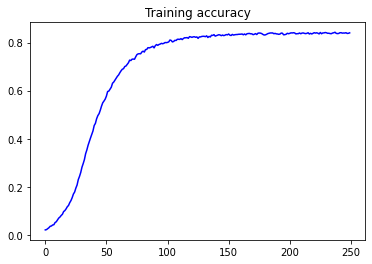

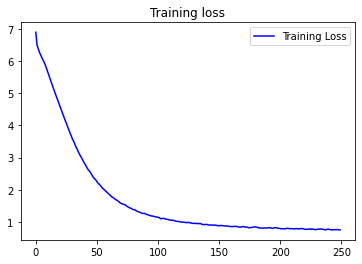

In [23]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [24]:
model1 = create_model1(total_words, max_sequence_len)
model1.summary()
# Train the model
history = model1.fit(features, labels, epochs=250, verbose=1, callbacks=[callbacks])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 100)           321100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 350)          386400    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 350)           0         
                                                                 
 lstm_3 (LSTM)               (None, 125)               238000    
                                                                 
 dense_2 (Dense)             (None, 1605)              202230    
                                                                 
 dense_3 (Dense)             (None, 3211)              5156866   
                                                      

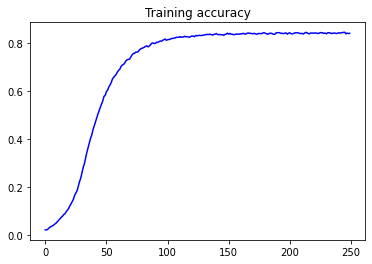

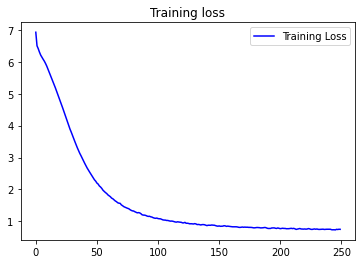

In [25]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [26]:
model2 = create_model2(total_words, max_sequence_len)
model2.summary()
# Train the model
history = model2.fit(features, labels, epochs=250, verbose=1, callbacks=[callbacks])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 100)           321100    
                                                                 
 bidirectional_2 (Bidirectio  (None, 10, 300)          301200    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 10, 300)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 1605)              162105    
                                                                 
 dense_5 (Dense)             (None, 3211)              5156866   
                                                      

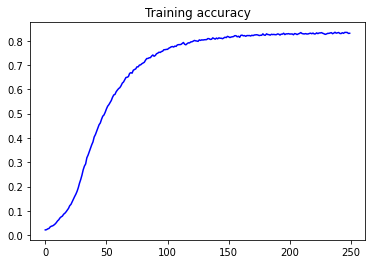

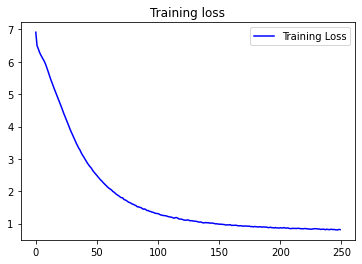

In [27]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [28]:
model3 = create_model3(total_words, max_sequence_len)
model3.summary()
# Train the model
history = model3.fit(features, labels, epochs=250, verbose=1, callbacks=[callbacks])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 100)           321100    
                                                                 
 bidirectional_3 (Bidirectio  (None, 10, 300)          301200    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 10, 300)           0         
                                                                 
 lstm_7 (LSTM)               (None, 150)               270600    
                                                                 
 dense_6 (Dense)             (None, 1605)              242355    
                                                                 
 dense_7 (Dense)             (None, 3211)              5156866   
                                                      

'model1' is the best model because have the highest accuracy and lowest loss paramter.

## See model in action

After all, it is finally time to see your model generating text. 

The cell below to generate the next 100 words of a seed text.

In [30]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model1.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope too much fair begin erred appetite more of mine eye things will that rare still so true all more tongue still brought of 'will eye bad or me for thee did know you for me name before thee light rare dearer delight night more delight can burn face weeds weeds night form both best living silence have dwell in one of thy sun sun beauty mad aside burn of sit best live eyes do blot the sun in sweetest parts thine eye of thee well eyes were seem disgrace so near more glory me of of life eyes ride see
